<a href="https://colab.research.google.com/github/anoooj0/Wisconsin-Autonomous-Perception-Coding-Challenge---Anuj-Shrestha-Submission/blob/main/Wisconsin_Autonomous_Coding_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from google.colab import drive
from sklearn.linear_model import RANSACRegressor

In [14]:
drive.mount('/content/drive')

# Path to the zip file
zip_path = '/content/drive/MyDrive/Cone.zip'
# Verify the file exists
if not os.path.exists(zip_path):
    print(f"Error: File not found at {zip_path}")
    print("Please check the file path and try again.")
else:
    # Directory to extract the files
    extract_dir = '/content/dataset'

    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"Files extracted to {extract_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to /content/dataset


In [15]:
dataset_path = '/content/dataset'

train_images_path = os.path.join(dataset_path, 'train')

Processed image saved as answer.png


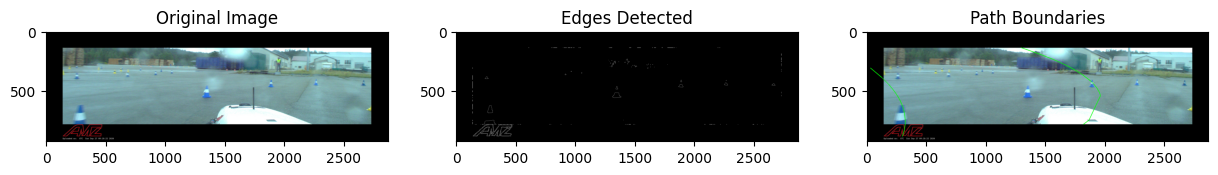

In [32]:
# Function to detect cone boundaries and draw path lines
def detect_cone_boundaries(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None

    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(hsv, (5, 5), 0)

    # Define color range for orange and blue cones (adjust if needed)
    lower_orange = np.array([5, 100, 100])  # Lower bound of orange
    upper_orange = np.array([25, 255, 255])  # Upper bound of orange
    lower_blue = np.array([100, 150, 50])  # Lower bound of blue
    upper_blue = np.array([140, 255, 255])  # Upper bound of blue

    # Create masks for cones
    mask_orange = cv2.inRange(blurred, lower_orange, upper_orange)
    mask_blue = cv2.inRange(blurred, lower_blue, upper_blue)
    mask = cv2.bitwise_or(mask_orange, mask_blue)

    # Apply edge detection
    edges = cv2.Canny(mask, 50, 150)

    # Find contours from the edge-detected mask
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding box centers to define path
    cone_centers = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        center_y = y + h // 2
        cone_centers.append((center_x, center_y))

    # Sort cone centers by y-coordinate to follow the path
    cone_centers = sorted(cone_centers, key=lambda p: p[1])

    # Separate left and right cones based on x-coordinate mean
    if len(cone_centers) > 1:
        mean_x = np.mean([p[0] for p in cone_centers])
        left_cones = sorted([p for p in cone_centers if p[0] < mean_x], key=lambda p: p[1])
        right_cones = sorted([p for p in cone_centers if p[0] >= mean_x], key=lambda p: p[1])

        def fit_polynomial(cones, degree=2):
            if len(cones) > 2:
                X = np.array([p[1] for p in cones])  # y-coordinates as input
                y = np.array([p[0] for p in cones])  # x-coordinates as output
                coeffs = np.polyfit(X, y, degree)
                poly_func = np.poly1d(coeffs)
                fitted_x = poly_func(X)
                return list(zip(fitted_x.astype(int), X.astype(int)))
            return cones

        left_cones = fit_polynomial(left_cones)
        right_cones = fit_polynomial(right_cones)

        # Draw boundary lines
        if len(left_cones) > 1:
            cv2.polylines(image, [np.array(left_cones)], isClosed=False, color=(0, 255, 0), thickness=3)
        if len(right_cones) > 1:
            cv2.polylines(image, [np.array(right_cones)], isClosed=False, color=(0, 255, 0), thickness=3)

        # Draw center path
        if len(left_cones) == len(right_cones) and len(left_cones) > 1:
            center_path = [((l[0] + r[0]) // 2, (l[1] + r[1]) // 2) for l, r in zip(left_cones, right_cones)]
            cv2.polylines(image, [np.array(center_path)], isClosed=False, color=(255, 0, 0), thickness=3)

    return image, edges

# Path to dataset
dataset_path = '/content/dataset/train'  # Adjust if needed

# Process first image in dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
if image_files:
    image_path = os.path.join(dataset_path, image_files[0])
    output_image, edges = detect_cone_boundaries(image_path)

    if output_image is not None:
        # Save the output image with drawn path
        output_path = 'answer.png'
        cv2.imwrite(output_path, output_image)
        print(f"Processed image saved as {output_path}")

        # Display results
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))

        plt.subplot(1, 3, 2)
        plt.title("Edges Detected")
        plt.imshow(edges, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Path Boundaries")
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

        plt.show()
else:
    print("No image files found in dataset path.")

Processed image saved as answer.png


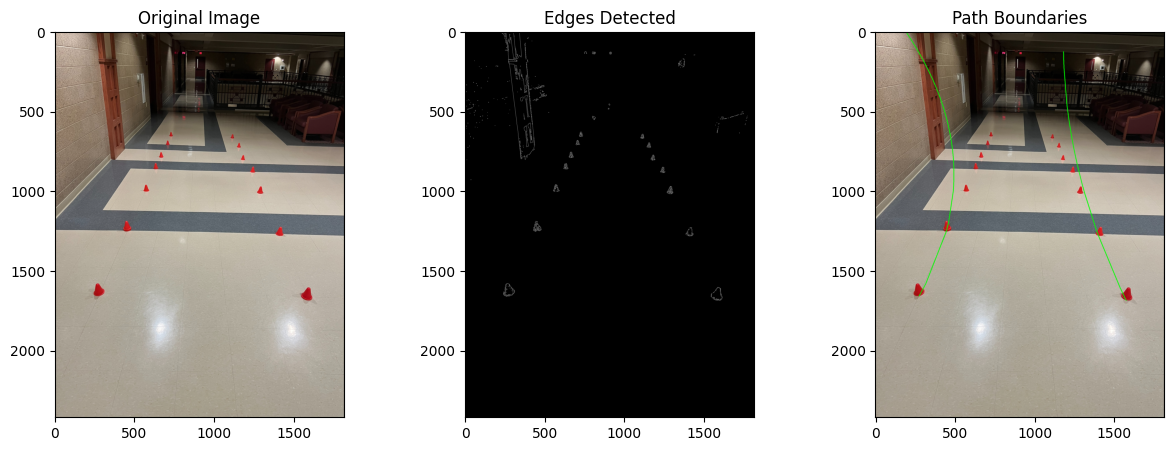

In [33]:
# Path to your test image
test_image_path = "/content/cones.png"  # Ensure this matches your uploaded image path

# Process the test image
output_image, edges = detect_cone_boundaries(test_image_path)

if output_image is not None:
    # Save the output image with drawn path
    output_path = "answer.png"
    cv2.imwrite(output_path, output_image)
    print(f"Processed image saved as {output_path}")

    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Edges Detected")
    plt.imshow(edges, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Path Boundaries")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    plt.show()
else:
    print("Error processing the image.")
